## SIMULATOR AND SUMMARY STATISTICS

In [1]:
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
sys.path.append("./../..")

In [2]:
# Load the minimum required library to run the functions
#from Utils_functions import *
from InternalLibrary.StatisticalFunctions import *
from InternalLibrary.SimulatorPackage import Simulator_noGPU

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from tqdm import tqdm
import _pickle as pickle


2024-05-20 17:06:13.847442: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-20 17:06:14.170135: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 17:06:14.170240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 17:06:14.216834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-20 17:06:14.317509: I tensorflow/core/platform/cpu_feature_guar

In [3]:
dt = 1e-6# The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
Sample_frequency = 25_000 # The sampling frequency. This is the number of samples that are recorded per unit time
DeltaT = 1/Sample_frequency # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
TotalT = 13 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent
transient = 3
t_corr = TotalT/50

# n_sim = int(10)


In [4]:
time_steps_amount = np.int64((TotalT-transient)/dt) # Number of steps
sampled_point_amount = np.int64((TotalT-transient)/DeltaT) # Number of sampled points
sampling_delta_time_steps = np.int64(DeltaT/dt) # Number of steps between samples
t = np.linspace(0., TotalT - transient, sampled_point_amount) # Time array

In [5]:
# Limits for the parameters (kbT=3.8 pN nm)
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}

In [6]:
tnice = [DeltaT for t in range(sampled_point_amount - 1)]

In [7]:
# Dummy call to compile the simulator
theta, theta_torch = get_theta_from_prior(prior_limits, 1)
Simulator_noGPU(0.1, 0.1, 0.5, theta);

### If you want to compute simulations

In [23]:
n_sim = int(10)

In [24]:
%%time
theta, theta_torch = get_theta_from_prior(prior_limits, n_sim)
x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta, transient_time = transient)

CPU times: user 35 s, sys: 89.5 ms, total: 35 s
Wall time: 35 s


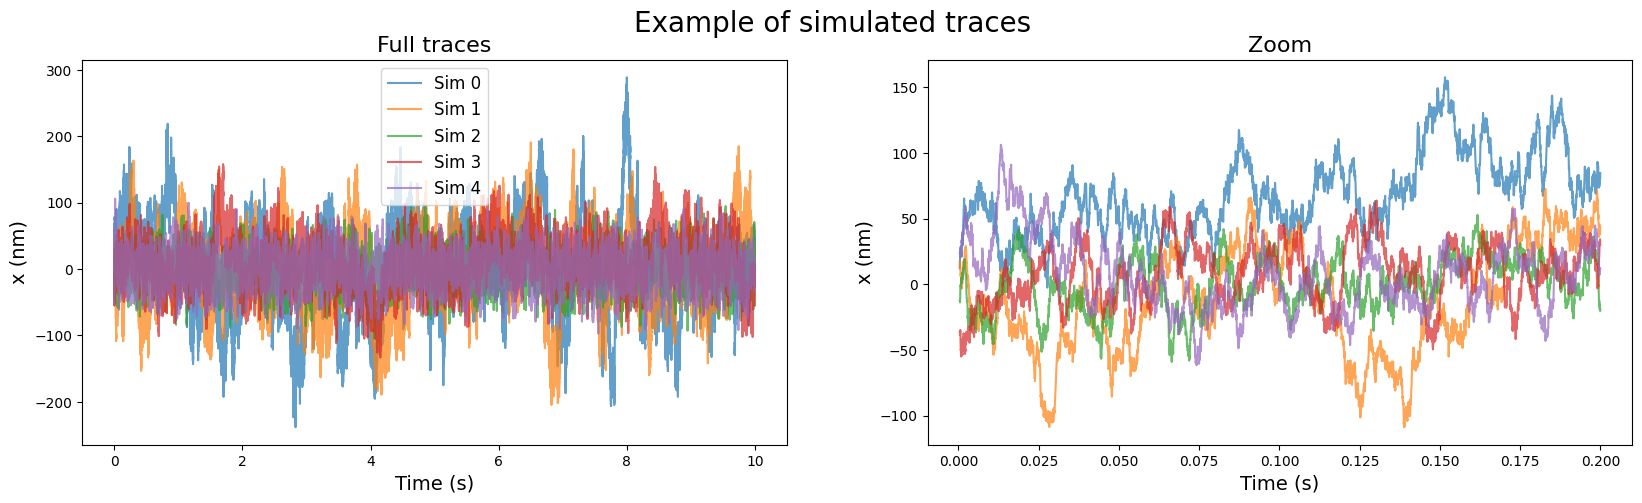

In [25]:
# Example of simulated traces
plt.figure(figsize=(20, 5))
plt.suptitle("Example of simulated traces", fontsize=20)

plt.subplot(121)
for i in range(min([n_sim, 5])):
    plt.plot(t, x_trace[i], label=f"Sim {i}", alpha=0.7)
plt.title("Full traces", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("x (nm)", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
for i in range(min([n_sim, 5])):
    plt.plot(t[10:5000], x_trace[i, 10:5000], label=f"Sim {i}", alpha=0.7)
plt.title("Zoom", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("x (nm)", fontsize=14);


In [51]:
def compute_summary_statistics(single_x_trace, single_theta, DeltaT = 1/25e3, TotalT = 10):
    summary_statistics = {}
    t = np.linspace(0., TotalT, single_x_trace.shape[0])
    t_corr = TotalT/20 # Hyperparameter
    
    # Autocorrelation
    Cxx = stat_corr_single(single_x_trace, DeltaT)
    idx_corr = where((t>0)*(t<t_corr))[0]
    cxx = Cxx[idx_corr]
    summary_statistics["Cxx"] = cxx  

    idx_clean_corr = np.linspace(0, len(cxx)-1, 500, dtype=np.int32)
    idx_clean_corr_log = np.logspace(0, np.log10(len(cxx)-1), 20, dtype=np.int32)
    summary_statistics["Cxx_cl_lin"] = cxx[idx_clean_corr]
    summary_statistics["Cxx_cl_log"] = cxx[idx_clean_corr_log]
    
    # S red
    S_red1, S_red2, S_red = stat_s_redx(Cxx, t_corr, t)
    summary_statistics["s_red1"] = S_red1
    summary_statistics["s_red2"] = S_red2
    summary_statistics["s_redx"] = S_red 

    summary_statistics["s_redx_cl_lin"] = S_red[idx_clean_corr]
    summary_statistics["s_redx_cl_log"] = S_red[idx_clean_corr_log]
    
    # Power spectral density
    psdx = stat_psd(single_x_trace, nperseg=1000, Sample_frequency=1/DeltaT)
    summary_statistics["psdx"] = psdx
    
    # Time series of the power spectral density and the x_trace
    summary_statistics["ts_psdx"] = stat_timeseries(psdx)
    summary_statistics["ts_x"] = stat_timeseries(single_x_trace)
    
    # Hermite coefficients
    summary_statistics["hermite"] = stat_hermite(single_x_trace)

    # Cxx decomposition in Hermite Coefficients
    summary_statistics["modes"] = stat_mode(Cxx, 1e-6, mean(psdx))

    # Tucci's summary statistics
    summary_statistics["tucci"] = stat_Tucci(single_x_trace, 1000, 1/DeltaT, cxx, 1e-6, mean(psdx))
 
    # Parameters
    summary_statistics["theta"] = single_theta

    return summary_statistics

In [54]:
%%time
# Compute the summary statistics from the simulations 
selected_stats = ["s_redx"]
z_score = False

first = True
for i in range(5):
    print("i = ", i+1, " / ", i+1, end="\r")  
    summary_stats = compute_summary_statistics(x_trace[i], theta[:,i])
    s_i = select_summary_statistics(summary_stats, selected_stats, z_score=z_score)
    
    if first:
        s_tot = s_i
        theta_tot = torch.from_numpy(summary_stats["theta"]).to(torch.float32)
        summary_stats_length = [len(summary_stats[s]) for s in selected_stats]
        print("Length of each summary statistics: ", summary_stats_length)
        first = False
    else:
        s_tot = torch.cat((s_tot, s_i), dim=0)
        theta_tot = torch.cat((theta_tot, torch.from_numpy(summary_stats["theta"]).to(torch.float32)), dim=1)

print("s_tot shape: ", s_tot.shape, ",  theta_tot shape: ", theta_tot.shape)

Length of each summary statistics:  [12499]
s_tot shape:  torch.Size([5, 12499]) ,  theta_tot shape:  torch.Size([5, 5])
CPU times: user 47.3 s, sys: 16.2 ms, total: 47.3 s
Wall time: 47.2 s


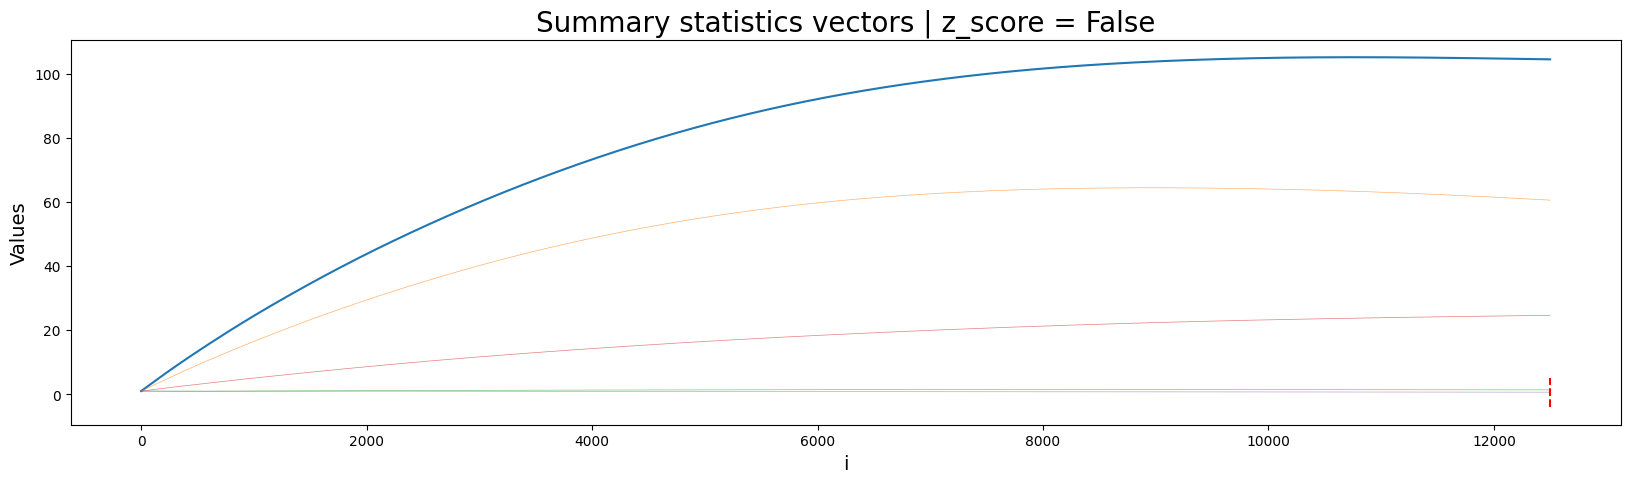

In [55]:
plt.figure(figsize=(20, 5))
plt.title("Summary statistics vectors | z_score = " + str(z_score), fontsize=20)
plt.xlabel("i", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.plot(s_tot[0, :])

for i in range(1, min([s_tot.shape[0], 5])):
    plt.plot(s_tot[i, :], lw=0.5, alpha=0.6)

plt.vlines(x=np.cumsum(summary_stats_length), ymin=-4, ymax=5, color='r', linestyles='dashed');

### If you want to load from file

In [8]:
# Modified version of the function that allows post-subselection of Cxx and s_redx
def select_summary_statistics(summary_statistics, selected_statistics, z_score=False, cl_lin=-1):
    # Check that the selected statistics are in the summary statistics
    assert set(selected_statistics).issubset(set(summary_statistics.keys()))
    "The selected statistics are not in the summary statistics"

    # Post-subselection of Cxx and s_redx
    if cl_lin > 0:
        idx_clean_corr = np.linspace(0, len(summary_statistics["Cxx"])-1, cl_lin, dtype=np.int32)
        if "Cxx" in selected_statistics:
            summary_statistics["Cxx"] = summary_statistics["Cxx"][idx_clean_corr]
        if "s_redx" in selected_statistics:
            summary_statistics["s_redx"] = summary_statistics["s_redx"][idx_clean_corr]
        if "s_red1" in selected_statistics:
            summary_statistics["s_red1"] = summary_statistics["s_red1"][idx_clean_corr]
        if "s_red2" in selected_statistics:
            summary_statistics["s_red2"] = summary_statistics["s_red2"][idx_clean_corr]

    # Check if theta is selected for testing reasons
    theta_selected = False
    if "theta" in selected_statistics:
        theta_selected = True
        selected_statistics.remove("theta")

    # Get the selected summary statistics in a torch tensor
    if z_score:
        list_of_statistics = [torch.tensor(zscore(summary_statistics[i])) for i in selected_statistics]
    else:   
        list_of_statistics = [torch.tensor(summary_statistics[i]) for i in selected_statistics]
    selected_summary_statistics = torch.cat(list_of_statistics, dim=0)
    selected_summary_statistics = torch.unsqueeze(selected_summary_statistics, 0)

    # Add theta to the summary statistics if selected
    if theta_selected:
        theta = torch.tensor(summary_statistics["theta"])
        selected_summary_statistics = torch.cat((selected_summary_statistics, theta.T), dim=1)

    # Convert the summary statistics to float32 (required for sbi)
    selected_summary_statistics = selected_summary_statistics.to(torch.float32)
    return selected_summary_statistics

In [18]:
%%time
# Hyperparameters
selected_stats = ["Cxx"] # selected summary statistics
z_score = False # z-score normalization of the summary statistics
cl_lin = -1 # linear post-subselection of Cxx and s_redx (-1 for no post-subselection)

# List file in the directory SummaryStatistics
#files = os.listdir("../../Data/SummaryStatistics/20240515/")[:-1]
files = [os.path.join(root, file)
        for root, _, files in os.walk("../../Data/SummaryStatistics/")
        for file in files][:1]
print("Reading ", len(files), " file for a total of ", 200*len(files), " simulations... \n")
loaded_simul = 0

# Pipeline from the n_sim simulations to the be ready for training
first = True
for file in files:
    print("Reading file", file, " i =", loaded_simul, " / ", 200*len(files), end='\r')
    with open(f"{file}", "rb") as f:
        summary_stats_batch = pickle.load(f)
    
    for i in range(len(summary_stats_batch)):
        # Here handle the local simulations
        summary_stats = summary_stats_batch[i]
        s_i = select_summary_statistics(summary_stats, selected_stats, z_score=z_score, cl_lin=cl_lin)
        if first:
            s_tot = s_i
            theta_tot = torch.from_numpy(summary_stats["theta"]).to(torch.float32)
            summary_stats_length = [len(summary_stats[s]) for s in selected_stats]
            print("Length of each summary statistics: ", summary_stats_length)
            first = False
        else:
            s_tot = torch.cat((s_tot, s_i), dim=0)
            theta_tot = torch.cat((theta_tot, torch.from_numpy(summary_stats["theta"]).to(torch.float32)), dim=1)
        
        loaded_simul += 1

theta_tot = theta_tot.T

print("Loaded simulations", loaded_simul)
print("s_tot.shape", s_tot.shape)
print("theta_tot.shape", theta_tot.shape)

Reading  1  file for a total of  200  simulations... 

Length of each summary statistics:  [833]/20240516/20240516-100634_200sims_process50961.pkl  i = 0  /  200
Loaded simulations 200
s_tot.shape torch.Size([200, 833])
theta_tot.shape torch.Size([200, 5])
CPU times: user 50.3 ms, sys: 9.07 ms, total: 59.4 ms
Wall time: 26.2 ms


### Visualization and normalization of $\theta$

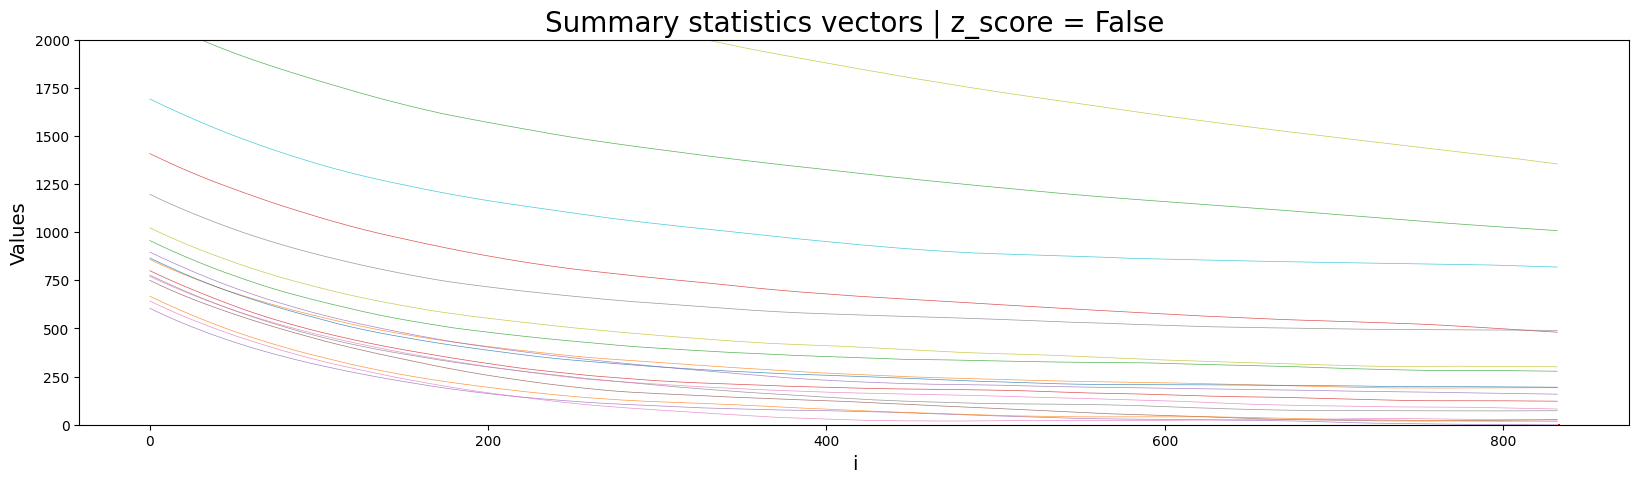

In [22]:
plt.figure(figsize=(20, 5))
plt.title("Summary statistics vectors | z_score = " + str(z_score), fontsize=20)
plt.xlabel("i", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.plot(s_tot[0, :], alpha=0.8)

for i in range(1, min([s_tot.shape[0], 20])):
    plt.plot(s_tot[i, :], lw=0.5, alpha=0.8)

plt.ylim(0, 2000)
plt.vlines(x=np.cumsum(summary_stats_length), ymin=-4, ymax=5, color='r', linestyles='dashed');

In [12]:
# Rescale also theta (not only the z-score on the summary statistics)
## Note that you have to change also the sampling limits in the prior_limits

def rescale_theta(theta_torch, prior_limits):
    theta_torch2 = theta_torch.clone()
    
    prior_limits_list = get_prior_limit_list(prior_limits)
    
    for i in range(theta_torch.shape[1]):
        prior_interval = prior_limits_list[i]
        theta_torch2[:, i] = (theta_torch2[:, i] - np.mean(prior_interval))/(prior_interval[1]-prior_interval[0])
    
    return theta_torch2

def rescale_theta_inv(theta_torch, prior_limits):
    theta_torch2 = theta_torch.clone()
    
    prior_limits_list = get_prior_limit_list(prior_limits)
    
    for i in range(theta_torch.shape[1]):
        prior_interval = prior_limits_list[i]
        theta_torch2[:, i] = theta_torch2[:, i]*(prior_interval[1]-prior_interval[0]) + np.mean(prior_interval)
    return theta_torch2

In [13]:
# Rescale the parameters in [-0.5, 0.5]
theta_tot_norm = rescale_theta(theta_tot, prior_limits)

## INFERENCE

Additional things to try:
* Combinatorial game out of the summary statistics
* Other SNPE methods (https://sbi-dev.github.io/sbi/tutorial/16_implemented_methods/)
* Multi-round training (defining a priori the observation)?

In [14]:
from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, SNPE_A, SNPE_C, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

In [15]:
# Prior distribution for sbi
prior_box = get_prior_box(prior_limits)

### Prior box if theta normalized:
prior_box = utils.torchutils.BoxUniform(low=torch.tensor([-0.5]*len(prior_limits)), high=torch.tensor([0.5]*len(prior_limits)))

prior, num_parameters, prior_returns_numpy = process_prior(prior_box)

In [16]:
# Call infer form sbi
infer = SNPE(prior=prior)
inferece = infer.append_simulations(theta_tot_norm, s_tot)

In [17]:
%%time
# Train the model
density_estimator = infer.train(num_atoms=20, show_train_summary=True, 
                                training_batch_size=1000, learning_rate=0.005) 
posterior = infer.build_posterior(density_estimator)

 Neural network successfully converged after 318 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 318
        Best validation performance: 4.2074
        -------------------------
        
CPU times: user 12min 2s, sys: 1.17 s, total: 12min 3s
Wall time: 3min 22s


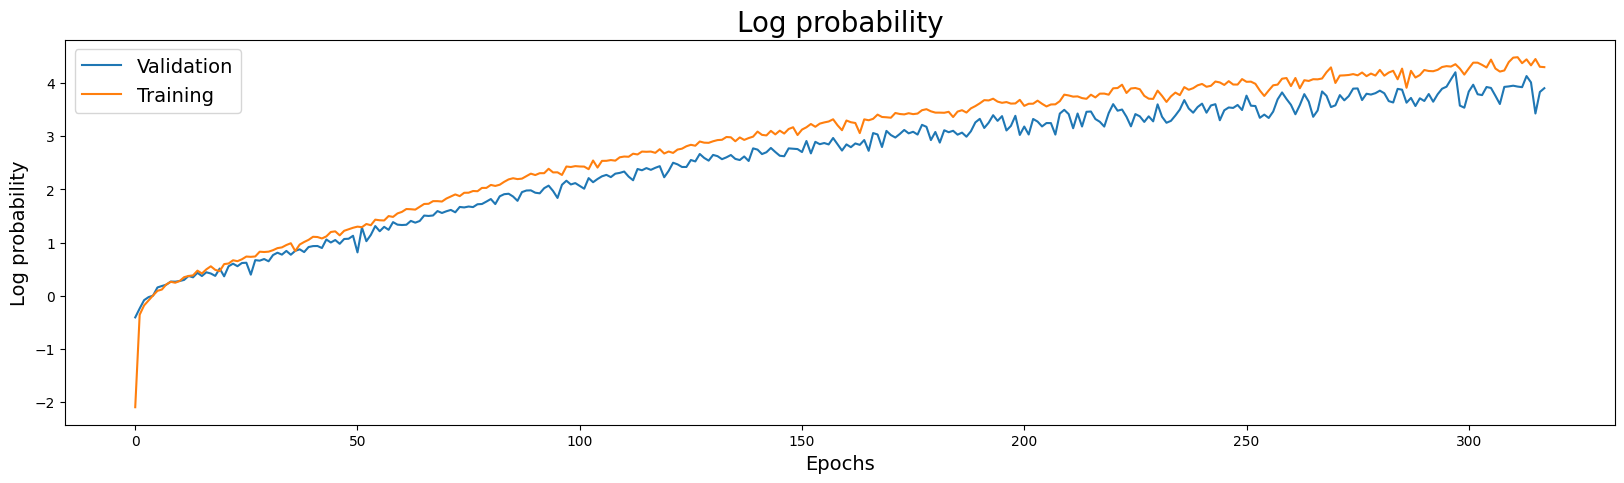

In [18]:
plt.figure(figsize=(20, 5))
plt.title("Log probability", fontsize=20)
plt.plot(infer.summary["validation_log_probs"], label="Validation")
plt.plot(infer.summary["training_log_probs"], label="Training")
plt.legend(fontsize=14)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Log probability", fontsize=14);

In [19]:
# with open("posterior_normalized_theta.pkl", "wb") as f:
#     pickle.dump(posterior, f)

In [20]:
# with open("posterior_normalized_theta.pkl", "rb") as f:
#     posterior = pickle.load(f)

In [29]:
# Get the observed trace
theta_true, theta_torch_true = get_theta_from_prior(prior_limits, 1)
x_trace_true, y_trace_true, f_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, theta_true, transient_time=transient)
print("theta_true.shape: ", theta_true.shape)
print("x_trace_true.shape: ", x_trace_true.shape)

theta_true.shape:  (5, 1, 1)
x_trace_true.shape:  (1, 249999)


In [30]:
# Compute the summary statistics for the observed trace
summary_stats_true = compute_summary_statistics(x_trace_true[0], theta_true[:, 0])
s_true = select_summary_statistics(summary_stats_true, selected_stats, z_score=z_score, cl_lin=cl_lin)

In [31]:
# Sample from the posterior
samples = posterior.sample((int(1e5),), x=s_true)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

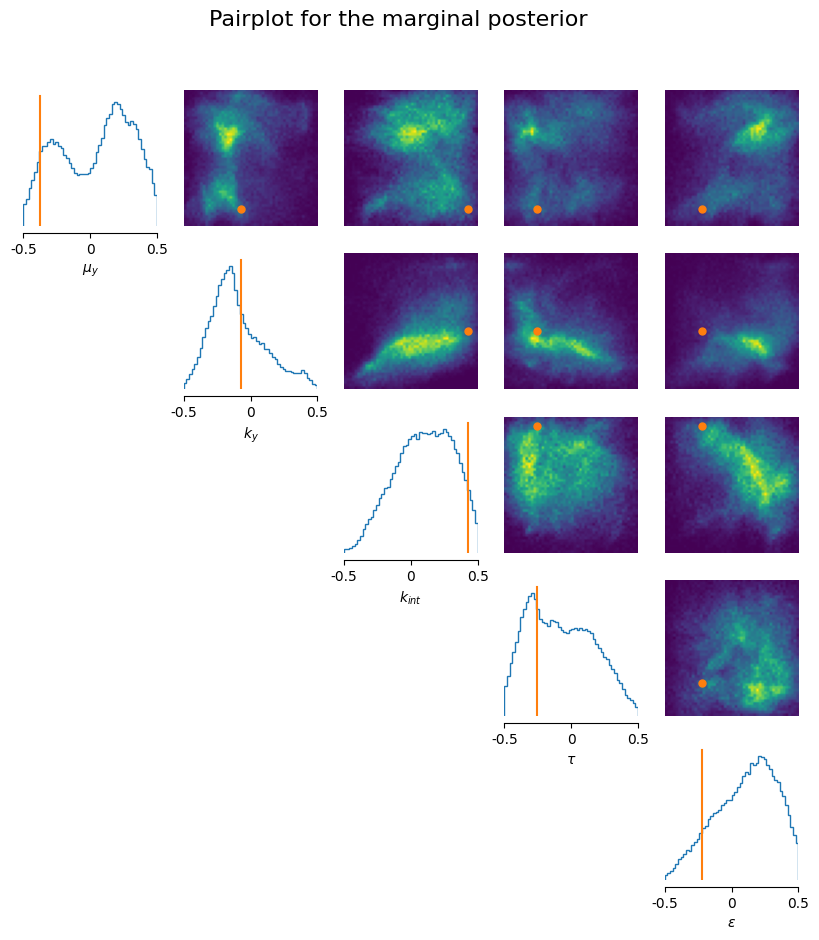

In [32]:
# Pairplot
label_theta = [r"$\mu_y$", r"$k_y$", r"$k_{int}$", r"$\tau$", r"$\varepsilon$"]
prior_limits_list = get_prior_limit_list(prior_limits)

prior_limits_list = [[-0.5, 0.5] for _ in range(len(prior_limits_list))]


_ = analysis.pairplot(samples, points=[rescale_theta(theta_torch_true.T, prior_limits)], 
                      limits=prior_limits_list, figsize=(10, 10), 
                      title = "Pairplot for the marginal posterior",
                      labels=label_theta)

## ENTROPY PRODUCTION & PERFORMANCES

These are the formulas used to compute the entropy production
$$
S = \sum_{t=0}^{N_{\text{timesteps}}-2} \left( \text{data}_{t+1} - \text{data}_{t} \right) \cdot F\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right) \cdot D^{-1}\left( \frac{\text{data}_{t+1} + \text{data}_{t}}{2} \right)
$$
$$
\sigma = \frac{{\mu_y \cdot \varepsilon^2}}{{1 + k_y \cdot \mu_y \cdot \tau - \frac{{k_{int}^2 \cdot \mu_x \cdot \mu_y \cdot \tau^2}}{{1 + k_x \cdot \mu_x \cdot \tau}}}}
$$

In [47]:
# Compute the mean and mode of the posterior for each parameter
def get_centroids_from_samples(samples):
    mean_params = np.array([])
    mode_params = np.array([])

    for i in range(5):
        # Retrive the samples for the parameter i
        params = samples[:,i].numpy()
        # Compute the mean
        mean_params = np.concatenate((mean_params, [np.mean(params)]))
        # Compute the mode
        hist, bin_edges = np.histogram(params, bins=int(np.sqrt(params.shape[0])))
        max_index = np.argmax(hist)
        mode = (bin_edges[max_index] + bin_edges[max_index+1])/2
        mode_params = np.concatenate((mode_params, [mode]))

    mean_params = mean_params.reshape(5, 1)
    mode_params = mode_params.reshape(5, 1)
    return mean_params, mode_params

get_centroids_from_samples(samples)

(array([[ 0.03708313],
        [-0.09583353],
        [ 0.09525036],
        [-0.07489116],
        [ 0.10474145]]),
 array([[ 0.18827192],
        [-0.15663821],
        [ 0.21994904],
        [-0.30538428],
        [ 0.23892033]]))

In [48]:
# Compare theoretical entropy with the one computed from the posterior
def CompareTheoreticalSigma(posterior, n_trials, n_samples, selected_stats=selected_stats, z_score=z_score):
    n_trials = int(n_trials)
    n_samples = int(n_samples)

    # Make n_trials simulations
    theta_true, theta_torch_true = get_theta_from_prior(prior_limits, n_trials)
    x_trace_true, y_trace_true, f_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, theta_true, transient_time=transient)

    sigma_true = ComputeTheoreticalEntropy(theta_true)[0]
    sigma_posterior = np.zeros((n_trials, n_samples))

    # Infer the posterior
    for i in range(n_trials):
        print("Making the statistics: i = ", i+1, " / ", n_trials, end="\r")
        summary_stats_true = compute_summary_statistics(x_trace_true[i], theta_true[:, i])
        s_true = select_summary_statistics(summary_stats_true, selected_stats, z_score=z_score, cl_lin=cl_lin)
        rescaled_samples = posterior.sample((n_samples,), x=s_true, show_progress_bars=False)
        samples = rescale_theta_inv(rescaled_samples, prior_limits)

        sigma_samples = ComputeTheoreticalEntropy(samples.numpy().T)[0]
        sigma_posterior[i, :] = sigma_samples[:, 0]

    return sigma_true, sigma_posterior

In [49]:
%%time
sigma_true, sigma_posterior = CompareTheoreticalSigma(posterior, 10, 1e5)

CPU times: user 2min 39s, sys: 249 ms, total: 2min 40s
Wall time: 2min 11s


In [50]:
def get_credibility_interval(single_sigma_posterior, c_level):
    pdf = np.sort(single_sigma_posterior)
    cdf = np.arange(1, len(pdf) + 1) / len(pdf)
    alpha = (1-c_level)/2
    region = pdf[(cdf > alpha) & (cdf < 1-alpha)]
    return region[0], region[-1]

get_credibility_interval(sigma_posterior[0], 0.95)

(523.2781625208581, 14768.274228905013)

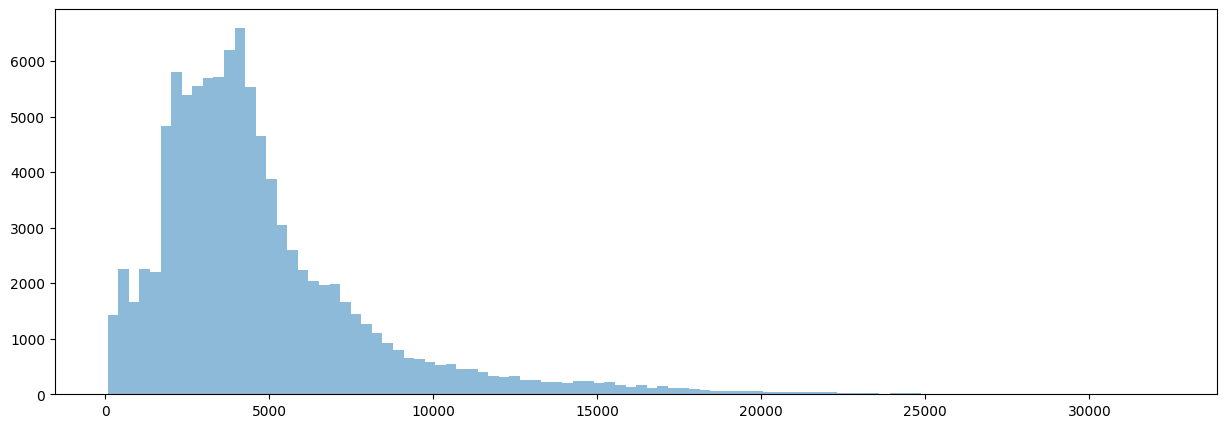

In [51]:
plt.figure(figsize=(15, 5))
plt.hist(sigma_posterior[0], bins=100, alpha=0.5, label="Posterior");

In [52]:
def get_mode(x):
    hist, bin_edges = np.histogram(x, bins=int(np.sqrt(len(x))))
    max_index = np.argmax(hist)
    mode = (bin_edges[max_index] + bin_edges[max_index+1])/2
    return mode

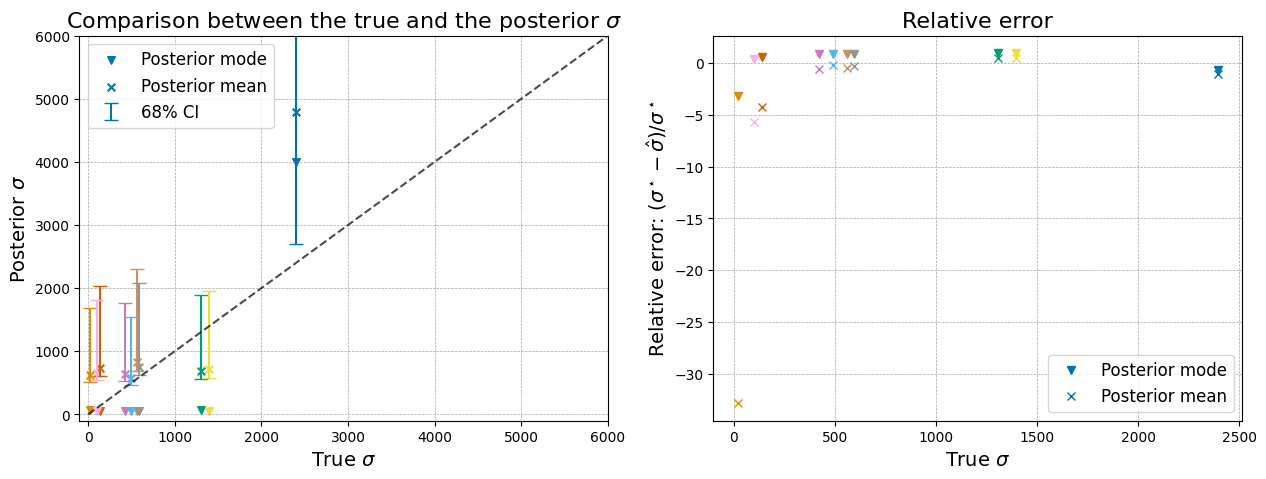

In [53]:
plt.figure(figsize=(15, 5))
colors = sns.color_palette("colorblind", n_colors=len(sigma_true))

plt.subplot(121)
for i in range(len(sigma_true)):
    mode = get_mode(sigma_posterior[i])
    mean = np.mean(sigma_posterior[i])
    cl = get_credibility_interval(sigma_posterior[i], 0.68)
    if i == 0:
        plt.scatter(sigma_true[i], mode, label=f"Posterior mode", s=30, marker="v", color=colors[i])
        plt.scatter(sigma_true[i], mean, label=f"Posterior mean", s=30, marker="x", color=colors[i])
        plt.errorbar(sigma_true[i], mean, yerr=[[cl[0]], [cl[1]]], 
                     fmt=' ', label=f"68% CI", capsize=5, color=colors[i])
    else:
        plt.scatter(sigma_true[i], mode, s=30, marker="v", color=colors[i])
        plt.scatter(sigma_true[i], mean, s=30, marker="x", color=colors[i])
        plt.errorbar(sigma_true[i], mean, yerr=[[cl[0]], [cl[1]]], 
                     fmt=' ', capsize=5, color=colors[i])

plt.xlim([-100, 6e3])
plt.ylim([-100, 6e3])
plt.plot([0, 6e3], [0, 6e3], color='black', linestyle='--', alpha=0.7)  
plt.xlabel(r"True $\sigma$", fontsize=14)
plt.ylabel(r"Posterior $\sigma$", fontsize=14)
plt.title(r"Comparison between the true and the posterior $\sigma$", fontsize=16)
plt.legend(loc="upper left", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

plt.subplot(122)
plt.title("Relative error", fontsize=16)
plt.xlabel("True $\sigma$", fontsize=14)
plt.ylabel(r"Relative error: $(\sigma^\star - \hat{\sigma})/\sigma^\star$", fontsize=14)
for i in range(len(sigma_true)):
    mode = get_mode(sigma_posterior[i])
    mean = np.mean(sigma_posterior[i])
    if i == 0:
        plt.plot(sigma_true[i], (sigma_true[i] - mode)/sigma_true[i], 'v', label=f"Posterior mode", color=colors[i])
        plt.plot(sigma_true[i], (sigma_true[i] - mean)/sigma_true[i], 'x', label=f"Posterior mean", color=colors[i])
    else:
        plt.plot(sigma_true[i], (sigma_true[i] - mode)/sigma_true[i], 'v', color=colors[i])
        plt.plot(sigma_true[i], (sigma_true[i] - mean)/sigma_true[i], 'x', color=colors[i])

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
plt.legend(loc="lower right", fontsize=12);

### Analytical entropy

Firstly, let's try looking at the distribution of sigma obtained just sampling the parameters from the prior (i.e. the distribution of "true sigma")

In [ ]:
# Function to test: when ready, move to Utils_functions.py
def comparison_sigma_analytical(n_test, n_sim_obs, 
                                prior_limits=prior_limits, list_stat=list_stat, t_corr=t_corr, t=t, DeltaT=DeltaT, dt=dt):
    sigma_true_array = np.zeros((n_test, 1))
    sigma_est_array = np.zeros((n_test, n_sim_obs))

    for i in range(n_test):
        # Get the true parameters and the n_sim_obs traces
        theta_true, _, _ = get_theta_from_prior(prior_limits, n_sim=n_sim_obs)
        x_trace_true, f_trace_true, _ = Simulator_noGPU(dt, DeltaT, TotalT, n_sim_obs, theta_true)
            
        # Compute the (true) entropy production analytically
        sigma_true, _, = compute_entropy_2(theta_true, 1)
        sigma_true_array[i] = sigma_true[0][0]

        # Get the summary statistics
        s = get_summary_statistics(list_stat, x_trace_true, f_trace_true, theta_true, DeltaT, 3, t, t_corr)

        for j in range(n_sim_obs):
            # Sample from the posterior
            samples = posterior.sample((int(1e5),), x=s[j, :], show_progress_bars=False)

            # Get the mean and mode parameters
            mean_params, mode_params = get_centroids_from_samples(samples)

            # Compute the entropy production analytically
            sigma_est_mode, _, = compute_entropy_2(mode_params, 1)
            sigma_est_array[i, j] = sigma_est_mode[0][0]    
    
    return sigma_true_array, sigma_est_array

In [ ]:
%%time
# Test on analytical entropy production on multiple realizations
n_test = 2  # Number of test realizations
n_sim_obs = 5  # Number of observed trace per realization

sigma_true_array, sigma_est_array = comparison_sigma_analytical(n_test, n_sim_obs)

In [ ]:
plt.figure(figsize=(15, 5))
plt.suptitle("Analytical entropy production: true vs estimated")

plt.subplot(121)
plt.xlabel(r"$\sigma_{true}$")
plt.ylabel(r"$\sigma_{est}$")
plt.scatter(sigma_true_array, np.mean(sigma_est_array, axis=1), label='mean on multiple realizations', color='red')
plt.errorbar(sigma_true_array, np.mean(sigma_est_array, axis=1), yerr=np.std(sigma_est_array, axis=1, ddof=1), 
             fmt=' ', capsize=3, label='std on multiple realizations', color='red')
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend()

plt.subplot(122)
color_palette_1 = sns.color_palette("pastel", n_test)
color_palette_2 = sns.color_palette("bright", n_test)

for i in range(n_test):
    plt.hist(sigma_est_array[i, :], alpha=0.5, label=f"Realization {i+1}", color=color_palette_1[i])
    plt.vlines(sigma_true_array[i], 0, n_sim_obs/n_test, color=color_palette_2[i], linestyle='--', label=f'True value {i+1}')
plt.xlabel(r"$\sigma$")
plt.ylabel("Counts")

plt.legend();

Now let's try a different approach. Instead of looking at the best estimates for the parameters, we'll use the entire posterior (of a single realization) to build a distribution of sigma.

In [ ]:
# Obtain the samples from the posterior of a single realization
theta_true, theta_torch_true, prior_box_true = get_theta_from_prior(prior_limits, 1)
x_trace_true, f_trace_true, y_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta_true)
s = get_summary_statistics(list_stat, x_trace_true, f_trace_true, theta_true, DeltaT, 3, t, t_corr)

samples = posterior.sample((int(1e5),), x=s)

In [ ]:
# Get the true entropy production
sigma_true_2 = compute_entropy_2(theta_true, 1)[0][0][0]

# Get the statistics of sigma directly out of the samples
sigma_samples = array([])
#sanity_check = array([])

for i in range(samples.shape[0]):
    sample = samples[i,:].numpy().reshape(9,1,1)
    #sanity_check = concatenate((sanity_check, [sample[0][0][0]]))
    sigma = compute_entropy_2(list(sample), 1)[0][0][0]
    sigma_samples = concatenate((sigma_samples, [sigma]))

In [ ]:
plt.xlim(0, 1e4)
plt.vlines(sigma_true_2, 0, 1e3, color='r')
print("True value: %.2f" % sigma_true_2)
plt.xlabel(r"$\sigma$")
plt.ylabel("Frequency")
plt.title("Sigma from sampling")
plt.hist(sigma_samples, bins=int(np.sqrt(len(sigma_samples))));

TO DO (when we'll have decent results): do the same but with multiple tests

### Experimental entropy

Fistly, let's look at the experimental entropy distribution obtain simply generating samples from the prior.

In [24]:
%%time
# Compute the obtained entropy production priors, individually for each simulation
emp_sigma_from_prior = np.array([])
sigma_from_prior = np.array([])

n_sim = int(1e4)
n_batch = int(1e2)

# n_sim = int(1e2)
# n_batch = int(1e1)

print("Computing %d simulations in %d batches" % (n_batch*(n_sim//n_batch), n_sim//n_batch))
for i in tqdm(range(n_sim//n_batch)):
    # Simulate the dynamics
    theta, theta_torch = get_theta_from_prior(prior_limits, n_sim//n_batch)
    x_trace, y_trace, f_trace = Simulator_noGPU(dt, DeltaT, TotalT, theta)

    # Compute the empirical entropy production
    _, _, _, emp_sigma = ComputeEmpiricalEntropy(x_trace, y_trace, f_trace, theta, n_batch, DeltaT)
    emp_sigma_from_prior = np.concatenate((emp_sigma_from_prior, emp_sigma))

    # Compute the analytical entropy production
    sigma_vec, _ = ComputeTheoreticalEntropy(theta, n_batch)
    sigma_from_prior = np.concatenate((sigma_from_prior, np.squeeze(sigma_vec)))

    # Clear the memory (for safety)
    #del theta, theta_torch, prior_box, x_trace, f_trace, y_trace
    #del emp_sigma_vec, sigma_vec

Computing 10000 simulations in 100 batches


100%|██████████| 100/100 [3:12:20<00:00, 115.41s/it] 

CPU times: total: 3h 8min 15s
Wall time: 3h 12min 20s


In [14]:
x_trace[0][1:].shape

(324999,)

In [15]:
x_trace[0][:-1].shape

(324999,)

In [58]:
import os

if not os.path.exists('data'):
    os.makedirs('data')
    
action = "save"

if action == "save":
    with open("data/sigma_from_prior.pkl", 'wb') as f:
        pickle.dump(sigma_from_prior, f)

    with open("data/emp_sigma_from_prior.pkl", 'wb') as f:
        pickle.dump(emp_sigma_from_prior, f)

    with open("data/theta.pkl", 'wb') as f:
        pickle.dump(theta, f)

if action == "load":
    with open("data/sigma_from_prior.pkl", 'rb') as f:
        sigma_from_prior = pickle.load(f)

    with open("data/emp_sigma_from_prior.pkl", 'rb') as f:
        emp_sigma_from_prior = pickle.load(f)

    with open("data/theta.pkl", 'rb') as f:
        theta = pickle.load(f)

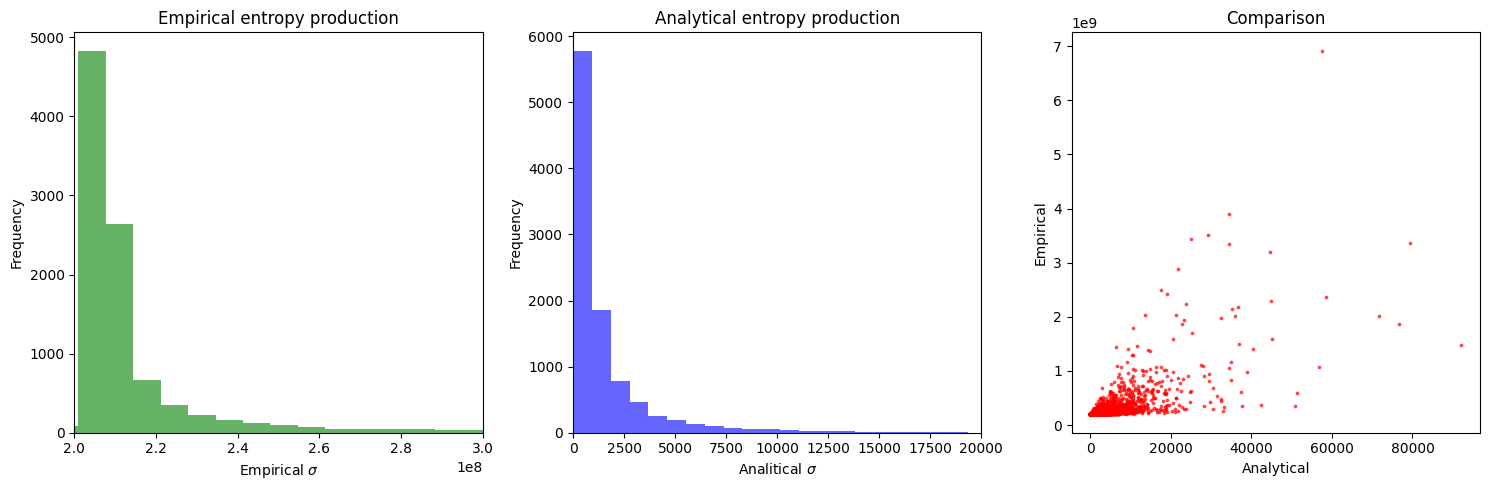

In [53]:
# do a figure with 3 subplots, 1 hist for empirical, 1 for analytical, 1 for the difference
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(emp_sigma_from_prior, bins=int(1e3),alpha=0.6, color='g')
ax[0].set_xlim(2e8, 0.3e9)
ax[0].set_title("Empirical entropy production")
ax[0].set_xlabel(r"Empirical $\sigma$")
ax[0].set_ylabel("Frequency")
ax[1].hist(sigma_from_prior, bins=int(np.sqrt(len(sigma_from_prior))),alpha=0.6, color='b')

ax[1].set_title("Analytical entropy production")
ax[1].set_xlabel(r"Analitical $\sigma$")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(0, 2e4)
ax[2].scatter(sigma_from_prior, emp_sigma_from_prior, alpha=0.6, color='r', s=3)
ax[2].set_title("Comparison")
ax[2].set_xlabel("Analytical")
ax[2].set_ylabel("Empirical")
plt.tight_layout()



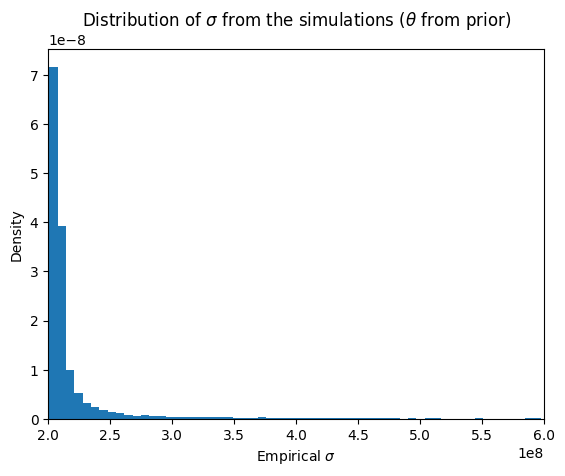

In [31]:
plt.hist(emp_sigma_from_prior, bins=int(1e3), density=True)
plt.xlim(0.2e9, 0.6e9)
plt.xlabel(r"Empirical $\sigma$")
plt.ylabel("Density")
plt.title(r"Distribution of $\sigma$ from the simulations ($\theta$ from prior)");

Let's compare the empirical and analytical sigma

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Lorenzo Vigorelli\AppData\Local\Temp\ipykernel_24032\3180162989.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.title("Analytical vs Empirical $\sigma$ (from prior)");


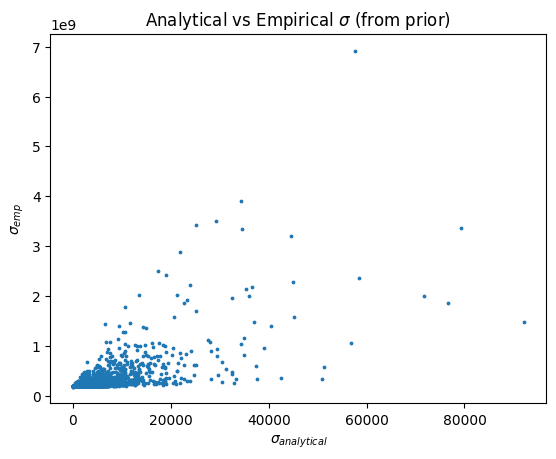

In [32]:
plt.scatter(sigma_from_prior, emp_sigma_from_prior, s=3)
plt.xlabel(r"$\sigma_{analytical}$")
plt.ylabel(r"$\sigma_{emp}$")
plt.title("Analytical vs Empirical $\sigma$ (from prior)");

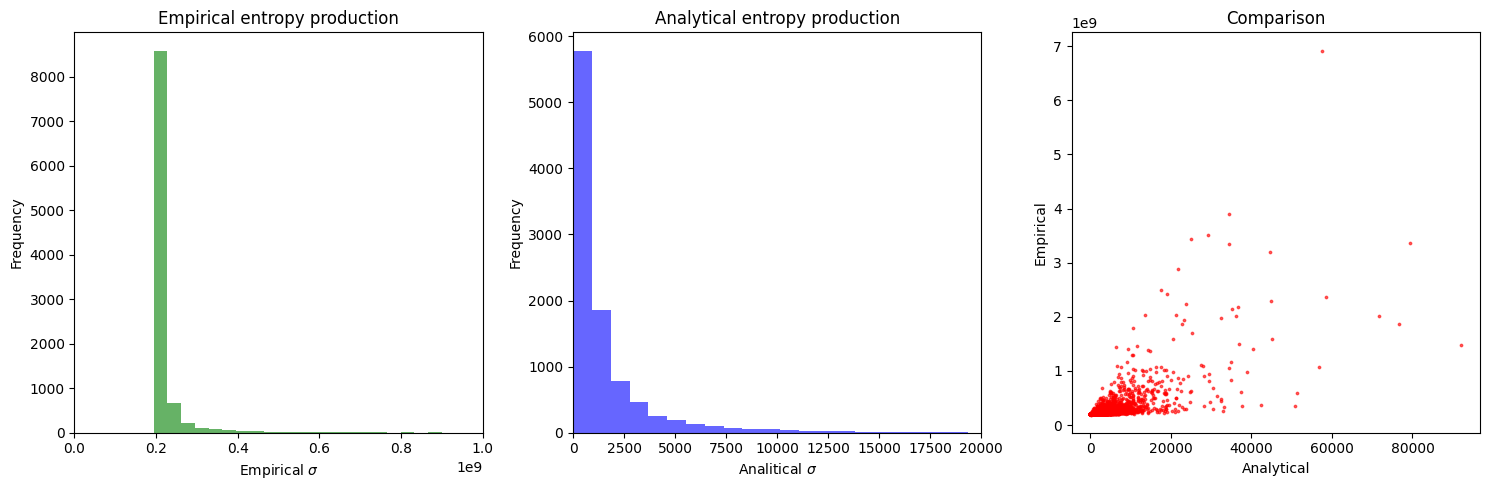

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Lorenzo Vigorelli\AppData\Local\Temp\ipykernel_24032\1558990474.py:2: SyntaxWarning: invalid escape sequence '\s'
  plt.title("Distribution of the analytical $\sigma$ from the prior", fontsize=20)


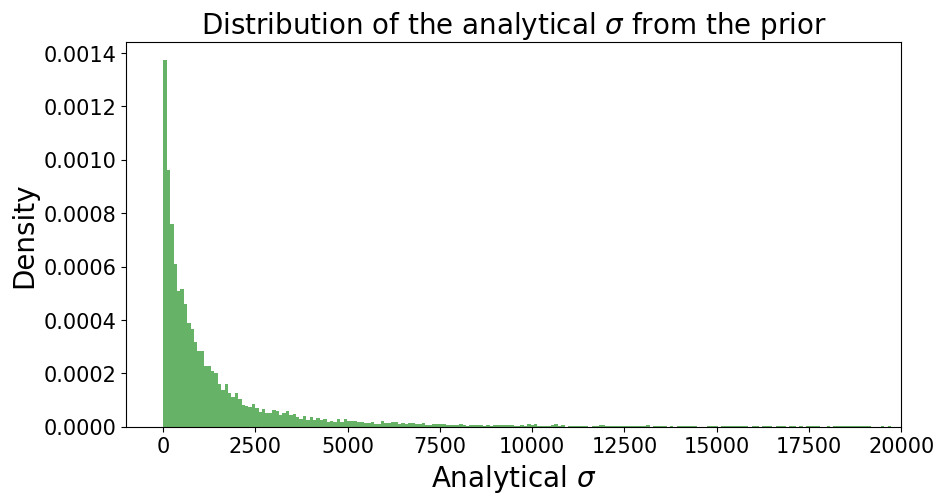

In [33]:
plt.figure(figsize=(10, 5))
plt.title("Distribution of the analytical $\sigma$ from the prior", fontsize=20)
plt.xlabel(r"Analytical $\sigma$", fontsize=20)
plt.ylabel("Density", fontsize=20)
plt.hist(sigma_from_prior, bins=int(1e3), density=True, alpha=0.6, color='g')
plt.xlim(-1000, 20000)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show();


Now let's look at the distribution of the empirical sigma for fixed parameters

In [ ]:
# %%time
# n_test = int(2e2)
# emp_sigma_fixed_theta = []

# # Sample the prior (once!)
# theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, 1)

# # Obtain the entropy production for different simulations
# for i in tqdm(range(n_test)):
#     x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta)
#     emp_sigma, _, _, _ = compute_entropy_production(x_trace, y_trace, f_trace, theta, 1)
#     emp_sigma_fixed_theta.append(emp_sigma)

In [ ]:
%%time
n_test = int(1e2)  # Number of independent tests
n_trial = int(1e2)  # Number of runs for each set of parameters

emp_sigma_fixed_theta = np.zeros((n_test, n_trial))

for i in tqdm(range(n_test)):
    # Sample the prior (once!)
    theta, theta_torch, prior_box = get_theta_from_prior(prior_limits, 1)
    theta_tile = np.tile(theta, (n_trial, 1))

    # Obtain the entropy production for different simulations
    x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, 5, n_trial, theta_tile)
    _, _, _, emp_sigma_vec = compute_entropy_production(x_trace, y_trace, f_trace, theta_tile, n_trial)
    emp_sigma_fixed_theta[i, :] = emp_sigma_vec

In [ ]:
# Save the data
action = "load"

if action == "save":
    with open("data/emp_sigma_fixed_theta.pkl", 'wb') as f:
        pickle.dump(emp_sigma_fixed_theta, f)

if action == "load":
    with open("data/emp_sigma_fixed_theta.pkl", 'rb') as f:
        emp_sigma_fixed_theta = pickle.load(f)

In [ ]:
plt.figure(figsize=(17, 5))

plt.subplot(131)
plt.hist(emp_sigma_fixed_theta[9, :], bins=15, density=True, color='#ACC8E5')
plt.xlabel(r"Empirical $\sigma$")
plt.ylabel("Density")
plt.title(r"Distribution of $\sigma_{emp}$ ($\theta$ fixed)")
m = np.mean(emp_sigma_fixed_theta[9, :])
s = np.std(emp_sigma_fixed_theta[9, :])
plt.errorbar(m, 0.02, xerr=s, fmt='o', color='#112A46', capsize=5)
plt.text(1186, 0.016, r"std($\sigma_{emp}$)=%.2f" % s, color='#112A46', fontsize=15)
plt.text(1203, 0.048, r"%d runs with $\theta$ fixed" % emp_sigma_fixed_theta.shape[1], 
         color='#112A46', fontsize=10)

plt.subplot(132)
plt.hist(np.std(emp_sigma_fixed_theta, axis=1), bins=15, density=True, color="#F8C794")
plt.xlabel(r"Std($\sigma_{emp}$)")
plt.ylabel("Density")
plt.title(r"Distribution of Std($\sigma_{emp}$) across realizations")
plt.text(130, 0.031, 
         f"%d realizations \n" % emp_sigma_fixed_theta.shape[0] + "with %d runs each" % emp_sigma_fixed_theta.shape[1], 
         color='#112A46', fontsize=10)

plt.subplot(133)
plt.scatter(np.mean(emp_sigma_fixed_theta, axis=1), 
            np.mean(emp_sigma_fixed_theta, axis=1)/np.std(emp_sigma_fixed_theta, axis=1), s=5)
plt.xlabel(r"Mean($\sigma_{emp}$)")
plt.ylabel(r"Relative error:  Mean($\sigma_{emp}$)/Std($\sigma_{emp}$)")
plt.title(r"Mean vs std($\sigma_{emp}$) across realizations")
plt.text(7200, 203, 
         f"%d realizations \n" % emp_sigma_fixed_theta.shape[0] + "with %d runs each" % emp_sigma_fixed_theta.shape[1], 
         color='#112A46', fontsize=10);
r = np.corrcoef(np.mean(emp_sigma_fixed_theta, axis=1), np.mean(emp_sigma_fixed_theta, axis=1)/np.std(emp_sigma_fixed_theta, axis=1))[0, 1]
plt.text(7200, 180, "Pearson: %.2f" % r, color='#112A46', fontsize=12);

Now let's introduce SBI and the posterior. Firstly, let's sample from a single realization of the sbi and simulate the dynamics (once for computational reasons) to compute the corresponding empirical sigma

In [ ]:
%%time
# Get the true parameters (single realization)
theta_true, theta_torch_true, prior_box_true = get_theta_from_prior(prior_limits, 1)
x_trace_true, f_trace_true, y_trace_true = Simulator_noGPU(dt, DeltaT, TotalT, 1, theta_true)

true_sigma_emp = compute_entropy_production(x_trace_true, y_trace_true, f_trace_true, theta_true, 1)[0]

# Sample from the posterior (few points due to later computational cost)
s = get_summary_statistics(list_stat, x_trace_true, f_trace_true, theta_true, DeltaT, 3, t, t_corr)
samples = posterior.sample((int(2e2),), x=s, show_progress_bars=False)

# Compute for each sample the entropy production
emp_sigma_samples = array([])
for i in tqdm(range(samples.shape[0])):
    sample = samples[i,:].numpy().reshape(9,1,1)
    x_trace, f_trace, y_trace = Simulator_noGPU(dt, DeltaT, TotalT, 1, list(sample))
    emp_sigma, _, _, _ = compute_entropy_production(x_trace, y_trace, f_trace, list(sample), 1)
    emp_sigma_samples = concatenate((emp_sigma_samples, [emp_sigma]))

In [ ]:
plt.title(r"Distribution of $\sigma_{emp}$ from the posterior samples")
plt.hist(emp_sigma_samples, bins=int(np.sqrt(len(emp_sigma_samples))), density=True, label='Posterior')
plt.hist(emp_sigma_from_prior, bins=int(np.sqrt(len(emp_sigma_from_prior))), density=True, label='Prior', alpha=0.6)
plt.vlines(true_sigma_emp, 0, 0.003, color='r', label='True value')
plt.xlabel(r"Empirical $\sigma$")
plt.ylabel("Density")
plt.legend();

# QUESTIONS
- per calcolare S_red come summary statistics (come fatto da Dresda nel file) usiamo i parametri, non è un bias poi usarla come summary statistics nel neural network durante la SBI?
- qual è la formula corretta per l'entropia? Cosa abbiamo usato noi?
- limiti per la prior distribution sui parametri